 DAEDALUS – Distributed and Automated Evolutionary Deep Architecture Learning with Unprecedented Scalability

This research code was developed as part of the research programme Open Technology Programme with project number 18373, which was financed by the Dutch Research Council (NWO), Elekta, and Ortec Logiqcare.

Project leaders: Peter A.N. Bosman, Tanja Alderliesten
Researchers: Alex Chebykin, Arthur Guijt, Vangelis Kostoulas
Main code developer: Arthur Guijt

This notebook processes the data involved with the multi-objective experiments.
It requires a working installation of Python with pandas, and RPy2; alongside R with ggplot.

# Specification
These are basically the parameters that differ from problem to problem for the data processing,
placed on top for easy access. Ensure that the filenames below are correct!

In [1]:
problem_name = "bot_vs_bot"
path_data_hypervolume = "paper_multiobjective_9c2eeca_bot_vs_bot_hv.csv.gz"
path_data_archives = "2021-12-20-paper_multiobjective_9c2eeca_archives.zip"
path_data_references = "reference_fronts.zip"
columns_configuration = ["approach", "l", "fns"]
columns_run = columns_configuration + ["run"]

approach_relabeling = {
    "0--c0": "Objective / Domination",
    "0_-1--c8--x-1": "Asymmetric Kernel / Domination",
    "0_-1--c9--x-1": "Symmetric Kernel / Domination",
    "-3_-1--c0": "Objective / Scalarized",
    "-3_-1--c8--x-1": "Asymmetric Kernel / Scalarized",
    "-3_-1--c9--x-1": "Symmetric Kernel / Scalarized",
}

preferred_ordering = [
    "Objective / Domination",
    "Objective / Scalarized",
    "Asymmetric Kernel / Domination",
    "Asymmetric Kernel / Scalarized",
    "Symmetric Kernel / Domination",
    "Symmetric Kernel / Scalarized",
]
preferred_ordering_front = preferred_ordering + ["Best Known (Reference Front)"]

def run_to_elitist_archive(df):
    return "paper_multiobjective_9c2eeca_bot_vs_bot/approach_" + df["approach spec"].map(str) + "__run_" + df["run"].map(str) + "__l_" + df["l"].map(str) + "__fns_" + df["fns"].map(str) + "/elitist_archive.dat"

def run_to_reference_front(df):
    return "bot_bot/n_" + df["l"].map(str) + "__fns_" + df["fns"].map(str) + "__k_5__s0_0__s1_1.txt"

# Imports

In [2]:
import pandas as pd
import numpy as np
import zipfile

%load_ext rpy2.ipython
%Rdevice svg

C:\Program Files\Python310\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [12]:
%%R
library(ggplot2)
library(scales)
# Multi (color)scale!
library(ggnewscale) # Not actively used for publication plots, but used for some extra analysis in this notebook :)
# Interactive graphs
# library(plotly)

# tables & data processing in R
library(gt)
library(xtable)
library(dplyr)
library(tidyr)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




# Loading Data

In [4]:
# Load hypervolume data
data_hypervolume = pd.read_csv(path_data_hypervolume)
data_hypervolume["approach spec"] = data_hypervolume["approach"]
data_hypervolume["approach"] = data_hypervolume["approach"].replace(approach_relabeling)
data_hypervolume

,#evaluations,time (ms),hypervolume,approach,run,l,fns,approach spec
0,9937,23,0.736121,Objective / Domination,0,50,1,0--c0
1,19762,41,0.785231,Objective / Domination,0,50,1,0--c0
2,29484,59,0.855352,Objective / Domination,0,50,1,0--c0
3,49062,97,0.881845,Objective / Domination,0,50,1,0--c0
4,69628,140,0.897099,Objective / Domination,0,50,1,0--c0
...,...,...,...,...,...,...,...,...
131439,2158421,9854,0.971322,Objective / Scalarized,0,25,8,-3_-1--c0
131440,4302868,21635,0.971322,Objective / Scalarized,0,25,8,-3_-1--c0
131441,13207341,60151,0.972614,Objective / Scalarized,0,25,8,-3_-1--c0
131442,14691787,66701,0.998450,Objective / Scalarized,0,25,8,-3_-1--c0


In [5]:
# Determine which run is the median run for a configuration as representative of the final front.
# 1: determine the final hypervolume as we'll be plotting the final archive.
data_last_hypervolume = data_hypervolume.sort_values("#evaluations").groupby(columns_run).last().reset_index()
# 2: From this determine median hypervolume
data_last_hypervolume = data_last_hypervolume.merge(data_last_hypervolume.groupby(columns_configuration)["hypervolume"].median().rename("median hypervolume").reset_index())
data_last_hypervolume["d hv mhv"] = (data_last_hypervolume["hypervolume"] - data_last_hypervolume["median hypervolume"]).abs()
# 3: Find the nearest sample
data_last_hypervolume = data_last_hypervolume.groupby(columns_configuration).apply(lambda df: df.iloc[df["d hv mhv"].argmin()]).reset_index(drop=True)
data_last_hypervolume["archive path"] = run_to_elitist_archive(data_last_hypervolume)
data_last_hypervolume["reference path"] = run_to_reference_front(data_last_hypervolume)
data_last_hypervolume

,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,archive path,reference path
0,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt
1,Asymmetric Kernel / Domination,12,2,0,14611,49,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_2__k_5__s0_0__s1_1.txt
2,Asymmetric Kernel / Domination,12,4,0,4262,11,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_4__k_5__s0_0__s1_1.txt
3,Asymmetric Kernel / Domination,12,8,0,1486,4,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_8__k_5__s0_0__s1_1.txt
4,Asymmetric Kernel / Domination,25,1,0,4653864,101378,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_25__fns_1__k_5__s0_0__s1_1.txt
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Symmetric Kernel / Scalarized,50,8,0,11790791,367427,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_50__fns_8__k_5__s0_0__s1_1.txt
92,Symmetric Kernel / Scalarized,100,1,1,4687127,136377,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_1__k_5__s0_0__s1_1.txt
93,Symmetric Kernel / Scalarized,100,2,0,22541003,1013989,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_2__k_5__s0_0__s1_1.txt
94,Symmetric Kernel / Scalarized,100,4,0,16776624,596742,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_4__k_5__s0_0__s1_1.txt


In [6]:
data_last_hypervolume

,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,archive path,reference path
0,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt
1,Asymmetric Kernel / Domination,12,2,0,14611,49,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_2__k_5__s0_0__s1_1.txt
2,Asymmetric Kernel / Domination,12,4,0,4262,11,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_4__k_5__s0_0__s1_1.txt
3,Asymmetric Kernel / Domination,12,8,0,1486,4,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_8__k_5__s0_0__s1_1.txt
4,Asymmetric Kernel / Domination,25,1,0,4653864,101378,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_25__fns_1__k_5__s0_0__s1_1.txt
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Symmetric Kernel / Scalarized,50,8,0,11790791,367427,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_50__fns_8__k_5__s0_0__s1_1.txt
92,Symmetric Kernel / Scalarized,100,1,1,4687127,136377,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_1__k_5__s0_0__s1_1.txt
93,Symmetric Kernel / Scalarized,100,2,0,22541003,1013989,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_2__k_5__s0_0__s1_1.txt
94,Symmetric Kernel / Scalarized,100,4,0,16776624,596742,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_4__k_5__s0_0__s1_1.txt


In [7]:
# Load relevant reference fronts from zip
reference_fronts_zip = zipfile.ZipFile(path_data_references)

def load_reference_front_from_zip(path):
    with reference_fronts_zip.open(path) as f:
        df = pd.read_csv(f, sep=" ", header=None, skiprows=2, dtype={'solution': str})
        df["reference path"] = path
        return df

reference_fronts_df = pd.concat([
    load_reference_front_from_zip(reference_path)
    for reference_path in data_last_hypervolume["reference path"].unique()
])

# Rename to bring the definition in line with the other dataframe
reference_fronts_df = reference_fronts_df.rename(columns={0: "objective0", 1: "objective1"})

reference_fronts_df

,objective0,objective1,reference path
0,12,4,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt
1,11,8,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt
2,10,9,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt
3,7,10,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt
4,6,11,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt
...,...,...,...
31,62,96,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt
32,59,97,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt
33,56,98,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt
34,55,99,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt


In [8]:
# Load archives from zip
archives_zip = zipfile.ZipFile(path_data_archives)

def convert_solution_str_to_np(s):
    return np.array([int(a) for a in s])

def load_archives_from_zip(path):
    with archives_zip.open(path) as f:
        df = pd.read_csv(f, converters={'solution': convert_solution_str_to_np})
        df["archive path"] = path
        return df

archives_zip_df = pd.concat([
    load_archives_from_zip(archive_path)
    for archive_path in data_last_hypervolume["archive path"]
])
archives_zip_df

,objective0,objective1,constraint,solution,best_traps,archive path
0,6,11,0,"[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]","0,0",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
1,7,10,0,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]","0,0",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
2,10,9,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]","0,0",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
3,4,12,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","0,0",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
4,11,8,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]","0,0",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
...,...,...,...,...,...,...
34,72,89,0,"[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
35,74,87,0,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
36,73,88,0,"[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",paper_multiobjective_9c2eeca_bot_vs_bot/approa...
37,84,78,0,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","0,7",paper_multiobjective_9c2eeca_bot_vs_bot/approa...


# Plotting: Convergence Graphs

In [9]:
# Specifications for resampling
max_evaluations = 100_000_000
sample_every = 1_000_000

# Precompute bin each sample ends up in
data_resampled_hypervolume = data_hypervolume.copy()
data_resampled_hypervolume["#evaluations bin"] = (data_resampled_hypervolume["#evaluations"] / sample_every).apply(np.ceil) * sample_every

# Precompute the bins
l_bins = pd.DataFrame({"#evaluations bin": range(sample_every, max_evaluations + sample_every, sample_every)})

# Perform resampling per run
def resample_run(run_df):
    best_per_bin = run_df.groupby("#evaluations bin")["hypervolume"].max().reset_index()
    gap_filled   = l_bins.merge(best_per_bin, left_on="#evaluations bin", right_on="#evaluations bin", how="left").ffill()
    return gap_filled

data_resampled_hypervolume = data_resampled_hypervolume.groupby(columns_run).apply(resample_run).reset_index()

# Compute q05, q50 (median) and q95 per bin
data_quantiles_hypervolume = data_resampled_hypervolume.groupby(columns_configuration + ["#evaluations bin"])["hypervolume"].quantile([0.05, 0.5, 0.95]).unstack().reset_index()

# Convert to 1 - Hypervolume (such that a log plot can be used)
data_quantiles_hypervolume["Q_0.05(1 - HV)"] = 1 - data_quantiles_hypervolume[0.05]
data_quantiles_hypervolume["Q_0.5(1 - HV)"] = 1 - data_quantiles_hypervolume[0.5]
data_quantiles_hypervolume["Q_0.95(1 - HV)"] = 1 - data_quantiles_hypervolume[0.95]

data_quantiles_hypervolume

,approach,l,fns,#evaluations bin,0.05,0.5,0.95,Q_0.05(1 - HV),Q_0.5(1 - HV),Q_0.95(1 - HV)
0,Asymmetric Kernel / Domination,12,1,1000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
1,Asymmetric Kernel / Domination,12,1,2000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
2,Asymmetric Kernel / Domination,12,1,3000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
3,Asymmetric Kernel / Domination,12,1,4000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
4,Asymmetric Kernel / Domination,12,1,5000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9595,Symmetric Kernel / Scalarized,100,8,96000000,0.957704,0.972060,0.997949,0.042296,0.027940,0.002051
9596,Symmetric Kernel / Scalarized,100,8,97000000,0.957704,0.972655,0.997949,0.042296,0.027345,0.002051
9597,Symmetric Kernel / Scalarized,100,8,98000000,0.957704,0.972655,0.997949,0.042296,0.027345,0.002051
9598,Symmetric Kernel / Scalarized,100,8,99000000,0.957704,0.972655,0.997949,0.042296,0.027345,0.002051


In [10]:
# Some extra annotation to allow subsampling of number of points
# Otherwise the graph gets somewhat messy
number_of_points = 10
divisor = (max_evaluations - sample_every) / number_of_points

divided = data_quantiles_hypervolume["#evaluations bin"] // divisor
data_quantiles_hypervolume["show point"] = (divided != divided.shift(1)).fillna(True)

In [11]:
# Filter out smaller
data_quantiles_hypervolume_f = data_quantiles_hypervolume[data_quantiles_hypervolume["l"] > 25]

R[write to console]: Saving 15 x 3.5 in image



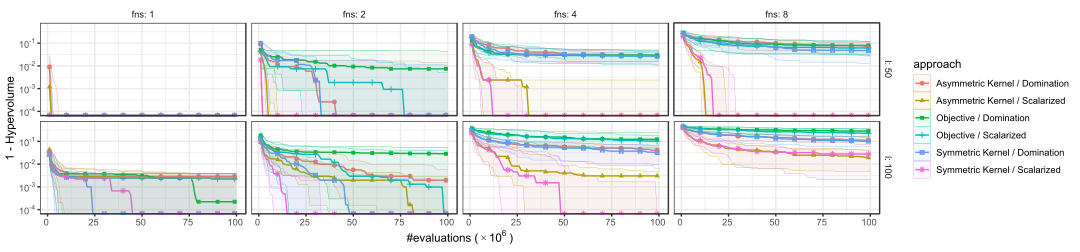

In [12]:
%%R -i problem_name -i data_quantiles_hypervolume_f -w 15 -h 3.5

plt <- ggplot(data_quantiles_hypervolume_f,
              aes(
                  x=`#evaluations bin`,
                  ymin=`Q_0.05(1 - HV)`,
                  y=`Q_0.5(1 - HV)`,
                  ymax=`Q_0.95(1 - HV)`,
                  color=`approach`,
                  fill=`approach`,
                  shape=`approach`)
              ) +
    geom_point(aes(alpha=`show point`)) + scale_alpha_identity(guide="none") +
    geom_line() +
    geom_ribbon(alpha = 0.05, size=0.1) +
    scale_y_log10(
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    scale_x_continuous(
        labels = unit_format(unit = "", scale = 1 / 1e+06, digits = 2)
    ) +
    labs(x =  expression("#evaluations (" %*% 10^6 ~ ")"), y = "1 - Hypervolume") +
    facet_grid(l ~ fns, label=label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste(problem_name, "_convergence_multiple_l.pdf", sep=""), device=cairo_pdf)

plt

Go down to $l = 100$, in order to avoid taking up too much space.

In [12]:
data_quantiles_hypervolume_f = data_quantiles_hypervolume[data_quantiles_hypervolume["l"] == 100]

R[write to console]: Saving 15 x 3.5 in image



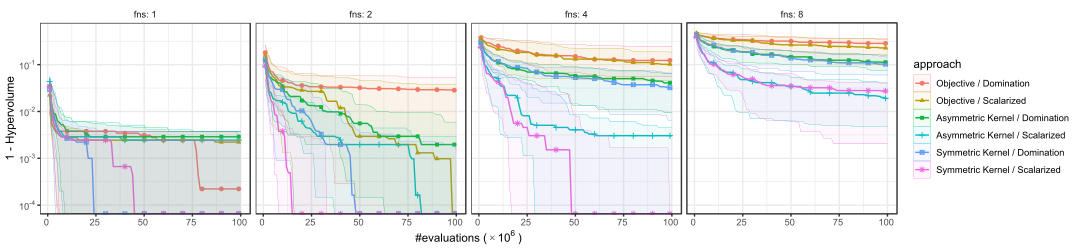

In [22]:
%%R -i preferred_ordering -i problem_name -i data_quantiles_hypervolume_f -w 15 -h 3.5
data_quantiles_hypervolume_f$approach = factor(data_quantiles_hypervolume_f$approach, levels=preferred_ordering)

plt <- ggplot(data_quantiles_hypervolume_f,
              aes(
                x=`#evaluations bin`,
                ymin=`Q_0.95(1 - HV)`,
                y=`Q_0.5(1 - HV)`,
                ymax=`Q_0.05(1 - HV)`,
                color=`approach`,
                fill=`approach`,
                shape=`approach`)
) +
geom_point(aes(alpha=`show point`)) + scale_alpha_identity(guide="none") +
geom_line() +
geom_ribbon(alpha = 0.05, size=0.1) +
scale_y_log10(
    breaks = trans_breaks("log10", function(x) 10^x),
labels = trans_format("log10", math_format(10^.x))
) +
scale_x_continuous(
    labels = unit_format(unit = "", scale = 1 / 1e+06, digits = 2)
) +
labs(x =  expression("#evaluations (" %*% 10^6 ~ ")"), y = "1 - Hypervolume") +
facet_grid(. ~ fns, label=label_both) +
theme_bw() +
theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste(problem_name, "_convergence_l100_os.pdf", sep=""), device=cairo_pdf)

plt

R[write to console]: Saving 15 x 2.5 in image



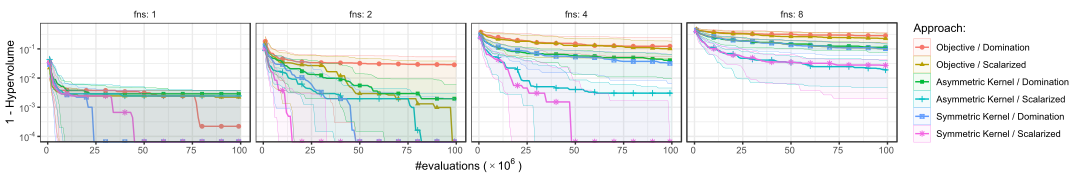

In [13]:
%%R -i preferred_ordering -i problem_name -i data_quantiles_hypervolume_f -w 15 -h 2.5
data_quantiles_hypervolume_f$approach = factor(data_quantiles_hypervolume_f$approach, levels=preferred_ordering)

plt <- ggplot(data_quantiles_hypervolume_f,
      aes(
        x=`#evaluations bin`,
        ymin=`Q_0.95(1 - HV)`,
        y=`Q_0.5(1 - HV)`,
        ymax=`Q_0.05(1 - HV)`,
        color=`approach`,
        fill=`approach`,
        shape=`approach`)
    ) +
    geom_point(aes(alpha=`show point`)) + scale_alpha_identity(guide="none") +
    geom_line() +
    geom_ribbon(alpha = 0.05, size=0.1) +
    scale_y_log10(
        breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x))
    ) +
    scale_x_continuous(
        labels = unit_format(unit = "", scale = 1 / 1e+06, digits = 2)
    ) +
    labs(x =  expression("#evaluations (" %*% 10^6 ~ ")"), y = "1 - Hypervolume", color="Approach:", fill="Approach:", shape="Approach:") +
    facet_grid(. ~ fns, label=label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste("2021-12-20-", problem_name, "_convergence_l100.pdf", sep=""), device=cairo_pdf)

plt

In [16]:
# ## # Reduced colors
##
## data_quantiles_hypervolume_f$approach = factor(data_quantiles_hypervolume_f$approach, levels=preferred_ordering)
##
## plt <- ggplot(data_quantiles_hypervolume_f,
##               aes(
##                 x=`#evaluations bin`,
##                 y=`Q_0.5(1 - HV)`,
##                 color=`approach`,
##                 fill=`approach`,
##                 shape=`approach`)
## ) +
## geom_point(aes(alpha=`show point`)) + scale_alpha_identity(guide="none") +
## geom_line() +
## scale_y_log10(
##     breaks = trans_breaks("log10", function(x) 10^x),
## labels = trans_format("log10", math_format(10^.x))
## ) +
## scale_x_continuous(
##     labels = unit_format(unit = "", scale = 1 / 1e+06, digits = 2)
## ) +
## labs(x =  expression("#evaluations (" %*% 10^6 ~ ")"), y = "1 - Hypervolume") +
## facet_grid(. ~ fns, label=label_both) +
## theme_bw() +
## theme(strip.background = element_rect(fill = NA, color=NA))
##
## ggsave(paste(problem_name, "_convergence_no_error_l100.pdf", sep=""))
##
## plt

# Plotting: Fronts

In [14]:
reference_approach_df = reference_fronts_df.merge(data_last_hypervolume, on="reference path")[["objective0", "objective1"] + [c for c in columns_configuration if c != "approach" ]].drop_duplicates()
reference_approach_df["approach"] = "Best Known (Reference Front)"
reference_approach_df["run"] = np.nan
reference_approach_df

,objective0,objective1,l,fns,approach,run
0,12,4,12,1,Best Known (Reference Front),NaN
6,11,8,12,1,Best Known (Reference Front),NaN
12,10,9,12,1,Best Known (Reference Front),NaN
18,7,10,12,1,Best Known (Reference Front),NaN
24,6,11,12,1,Best Known (Reference Front),NaN
...,...,...,...,...,...,...
1776,62,96,100,8,Best Known (Reference Front),NaN
1782,59,97,100,8,Best Known (Reference Front),NaN
1788,56,98,100,8,Best Known (Reference Front),NaN
1794,55,99,100,8,Best Known (Reference Front),NaN


In [15]:
approaches_chosen_archives_df = data_last_hypervolume.merge(archives_zip_df, on="archive path")[["objective0", "objective1"] + columns_run]
approaches_chosen_archives_df

,objective0,objective1,approach,l,fns,run
0,6,11,Asymmetric Kernel / Domination,12,1,0
1,7,10,Asymmetric Kernel / Domination,12,1,0
2,10,9,Asymmetric Kernel / Domination,12,1,0
3,4,12,Asymmetric Kernel / Domination,12,1,0
4,11,8,Asymmetric Kernel / Domination,12,1,0
...,...,...,...,...,...,...
1823,72,89,Symmetric Kernel / Scalarized,100,8,7
1824,74,87,Symmetric Kernel / Scalarized,100,8,7
1825,73,88,Symmetric Kernel / Scalarized,100,8,7
1826,84,78,Symmetric Kernel / Scalarized,100,8,7


In [16]:
fronts_df = pd.concat([approaches_chosen_archives_df, reference_approach_df])

In [17]:
fronts_df_f = fronts_df[fronts_df["l"] == 100]

R[write to console]: Saving 15 x 3.5 in image



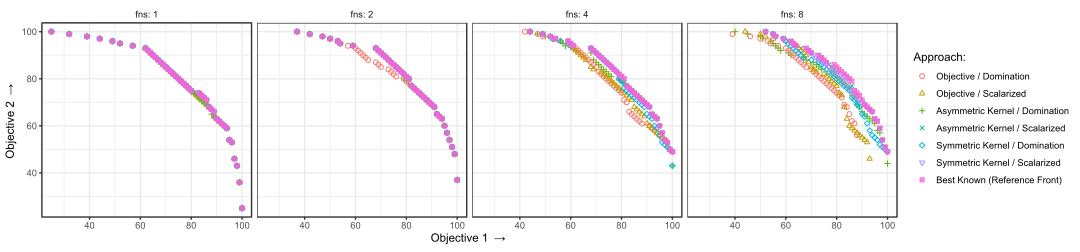

In [18]:
%%R -i preferred_ordering_front -i problem_name -i fronts_df_f -w 15 -h 3.5

fronts_df_f$approach = factor(fronts_df_f$approach, levels=preferred_ordering_front)

plt <- ggplot(fronts_df_f,
              aes(
                  x=`objective0`,
                  y=`objective1`,
                  color=`approach`,
                  shape=`approach`),
              fill=NA,
) +
geom_point() +
scale_shape_manual(values=1:length(preferred_ordering_front)) +
labs(x = expression("Objective 1 " %->% ""), y = expression("Objective 2 " %->% ""), color="Approach:", fill="Approach:", shape="Approach:") +
facet_grid(. ~ fns, label=label_both) +
theme_bw() +
theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste(problem_name, "_final_front_l100_os.pdf", sep=""), device=cairo_pdf)

plt

R[write to console]: Saving 15 x 2.5 in image



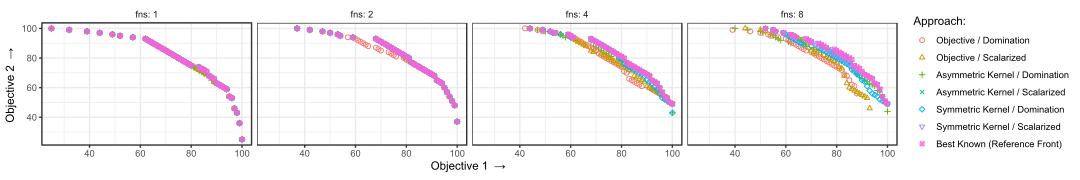

In [19]:
%%R -i preferred_ordering_front -i problem_name -i fronts_df_f -w 15 -h 2.5

fronts_df_f$approach = factor(fronts_df_f$approach, levels=preferred_ordering_front)

plt <- ggplot(fronts_df_f,
              aes(
                  x=`objective0`,
                  y=`objective1`,
                  color=`approach`,
                  shape=`approach`),
              fill=NA,
              ) +
geom_point() +
scale_shape_manual(values=1:length(preferred_ordering_front)) +
labs(x = expression("Objective 1 " %->% ""), y = expression("Objective 2 " %->% ""), color="Approach:", fill="Approach:", shape="Approach:") +
facet_grid(. ~ fns, label=label_both) +
theme_bw() +
theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste("2021-12-20-", problem_name, "_final_front_l100.pdf", sep=""), device=cairo_pdf)

plt

In [40]:
unpruned_archives_extra_info = data_last_hypervolume.merge(archives_zip_df, on="archive path")
unpruned_archives_extra_info

,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,archive path,reference path,objective0,objective1,constraint,solution,best_traps
0,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,6,11,0,"[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]","0,0"
1,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,7,10,0,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]","0,0"
2,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,10,9,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]","0,0"
3,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,4,12,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","0,0"
4,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,11,8,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]","0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,72,89,0,"[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1"
1824,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,74,87,0,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1"
1825,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,73,88,0,"[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1"
1826,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,84,78,0,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","0,7"


In [41]:
unpruned_archives_extra_info.groupby(["l", "fns"])["best_traps"].value_counts()

l    fns  best_traps
12   1    0,0           36
     2    0,0           12
          0,1           12
          1,0            6
     4    2,1           12
                        ..
100  8    2,1            3
          7,6            3
          2,4            2
          6,3            2
          0,4            1
Name: best_traps, Length: 91, dtype: int64

# Statistical Significance
Similarly to the statistical significance tests employed for, we apply statistical significance testing for the largest value for $l$. Unlike the single-objective experiments, this problem is significantly more difficult requiring approaches to find the full front. It is therefore likely that not the entirety of the front is found. We instead compare the distribution of hypervolume at the evaluation limit.

(Note: alternatively we can compute the area under the curve: see the next block)

In [15]:
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.
final_bin = data_resampled_hypervolume["#evaluations bin"].max()
final_hvs = data_resampled_hypervolume[(data_resampled_hypervolume["l"] == 100) & (data_resampled_hypervolume["#evaluations bin"] == final_bin)]
subsequences = final_hvs.groupby(["fns", "approach"])["hypervolume"].apply(list).reset_index()
pd_ordering_type = pd.api.types.CategoricalDtype(categories=preferred_ordering, ordered=True)
subsequences["approach"] = subsequences["approach"].astype(pd_ordering_type)
pairs_df = pd.merge(subsequences, subsequences, on="fns")

from scipy.stats import mannwhitneyu
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["hypervolume_x"], nan=np.inf),
        np.nan_to_num(df["hypervolume_y"], nan=np.inf),
        use_continuity = False, alternative="greater")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)
pairs_df.pivot(["fns", "approach_x"], "approach_y", "test p")

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = pairs_df.groupby("fns").apply(perform_comparison).reset_index(drop = True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
significant = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "H0 accepted")
test_p = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "test p")

def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"
    map_a = significant.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_styled = test_p.style.apply(styled, axis=None).format(na_rep="-", precision=3)
# test_p_styled.to_latex("./2021-12-23-paper_bot_vs_bot_significant.tex", hrules=True, convert_css=True)
test_p_styled


In [28]:
sig_counts = significant.stack().rename("sig").reset_index().groupby("approach_x")["sig"].sum().reset_index()
sig_counts["sig"] = sig_counts["sig"].astype(int).transform(str) + " (" + sig_counts["sig"].rank(ascending=False, method="dense").astype(int).transform(str) + ")"

sig_counts.rename(columns={"approach_x": "approach"}).to_latex("2021-12-23-paper_bot_vs_bot_significance_counts.tex", index=False)
sig_counts

,approach_x,sig
0,Objective / Domination,0 (6)
1,Objective / Scalarized,3 (5)
2,Asymmetric Kernel / Domination,5 (4)
3,Asymmetric Kernel / Scalarized,9 (2)
4,Symmetric Kernel / Domination,7 (3)
5,Symmetric Kernel / Scalarized,15 (1)


## Area-under-the-Curve

In [83]:
def compute_aoc(df, x, y, x_min, x_max, y_min, y_max, normalize = True):
    # To visualize area-under-the-curve, see the following schematic:
    #         |       first sample
    # y-max - | |---| /        sample in between
    #         | |   ._______ /          last sample
    #         | |           ._________ /
    #         | |    AOC              .___
    # y-min - | |________________________|
    #         L_____________________________
    #           ^ x-min                   ^ x-max

    #           ^---^
    #               ^-------^
    #                       ^---------^
    #                                 ^---^

    dx = pd.concat([pd.Series([x_min]), df[x], pd.Series([x_max])]).diff().shift(-1)
    ys = np.maximum(0.0, pd.concat([pd.Series([y_max]), df[y], pd.Series([y_min])]) - y_min)
    if normalize:
        return ((dx * ys).fillna(0).sum() / ((x_max - x_min) * (y_max - y_min)))
    else:
        return ((dx * ys).fillna(0).sum())

# compute_aoc(pd.DataFrame({ 'x': [0.5], 'y': [0.5]}), "x", "y", 0, 1, 0, 1)
# 0.5 * 1 + 0.5 * 0.5 + ??? * 0 = 0.75

SyntaxError: '(' was never closed (Temp/ipykernel_8636/266547086.py, line 22)

In [84]:
# AOC - Evaluations
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.

subs = data_hypervolume[data_hypervolume["l"] == 100].copy()
subs["1 - hypervolume"] = 1 - subs["hypervolume"]

measure = subs.\
    groupby(columns_run).\
    apply(lambda df: compute_aoc(df, "#evaluations", "1 - hypervolume", 0, 100_000_000, 0, 1.0)).\
    rename("aoc").\
    reset_index()

subsequences = measure.groupby(["fns", "approach"])["aoc"].apply(list).reset_index()
pd_ordering_type = pd.api.types.CategoricalDtype(categories=preferred_ordering, ordered=True)
subsequences["approach"] = subsequences["approach"].astype(pd_ordering_type)
pairs_df = pd.merge(subsequences, subsequences, on="fns")

from scipy.stats import mannwhitneyu
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["aoc_x"], nan=np.inf),
        np.nan_to_num(df["aoc_y"], nan=np.inf),
        use_continuity = False, alternative="less")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)
pairs_df.pivot(["fns", "approach_x"], "approach_y", "test p")

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = pairs_df.groupby("fns").apply(perform_comparison).reset_index(drop = True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
significant = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "H0 accepted")
test_p = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "test p")

def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"
    map_a = significant.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_styled = test_p.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_styled.to_latex("./2021-12-23-paper_bot_vs_bot_oac_evaluations_significant.tex", hrules=True, convert_css=True)
test_p_styled


In [85]:
# AOC - time
a = 0.05

subs = data_hypervolume[data_hypervolume["l"] == 100].copy()
subs["1 - hypervolume"] = 1 - subs["hypervolume"]

time_max = subs["time (ms)"].max()

measure = subs.\
    groupby(columns_run).\
    apply(lambda df: compute_aoc(df, "time (ms)", "1 - hypervolume", 0, time_max, 0, 1.0)).\
    rename("aoc").\
    reset_index()

subsequences = measure.groupby(["fns", "approach"])["aoc"].apply(list).reset_index()
pd_ordering_type = pd.api.types.CategoricalDtype(categories=preferred_ordering, ordered=True)
subsequences["approach"] = subsequences["approach"].astype(pd_ordering_type)
pairs_df = pd.merge(subsequences, subsequences, on="fns")

from scipy.stats import mannwhitneyu
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["aoc_x"], nan=np.inf),
        np.nan_to_num(df["aoc_y"], nan=np.inf),
        use_continuity = False, alternative="less")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)
pairs_df.pivot(["fns", "approach_x"], "approach_y", "test p")

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = pairs_df.groupby("fns").apply(perform_comparison).reset_index(drop = True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
significant = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "H0 accepted")
test_p = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "test p")

def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"
    map_a = significant.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_styled = test_p.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_styled.to_latex("./2021-12-23-paper_bot_vs_bot_oac_time_significant.tex", hrules=True, convert_css=True)
test_p_styled


# Tabulation

In [26]:
data_quantiles_hypervolume_last = data_quantiles_hypervolume[data_quantiles_hypervolume["#evaluations bin"] == data_quantiles_hypervolume["#evaluations bin"].max()]
data_quantiles_hypervolume_last = data_quantiles_hypervolume_last.drop(columns=["show point", "#evaluations bin", "Q_0.05(1 - HV)", "Q_0.5(1 - HV)", "Q_0.95(1 - HV)"])
data_quantiles_hypervolume_last

,approach,l,fns,0.05,0.5,0.95
99,Asymmetric Kernel / Domination,12,1,1.000000,1.000000,1.000000
199,Asymmetric Kernel / Domination,12,2,1.000000,1.000000,1.000000
299,Asymmetric Kernel / Domination,12,4,1.000000,1.000000,1.000000
399,Asymmetric Kernel / Domination,12,8,1.000000,1.000000,1.000000
499,Asymmetric Kernel / Domination,25,1,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
9199,Symmetric Kernel / Scalarized,50,8,1.000000,1.000000,1.000000
9299,Symmetric Kernel / Scalarized,100,1,0.997559,1.000000,1.000000
9399,Symmetric Kernel / Scalarized,100,2,1.000000,1.000000,1.000000
9499,Symmetric Kernel / Scalarized,100,4,1.000000,1.000000,1.000000


In [45]:
%%R -i data_quantiles_hypervolume_last
tab <- data_quantiles_hypervolume_last %>%
    # mutate(`hypervolume` = paste(`0.05`, "/", `0.5`, "/",`0.95`)) %>%
    # select(-c(`0.05`, `0.5`, `0.95`)) %>%
    pivot_wider(names_from = approach, values_from=c(`0.05`, `0.5`, `0.95`), names_sep= ".", names_glue = "{approach}_{.value}") %>%
    mutate(fns=paste("fns: ", fns)) %>%
    gt(groupname_col = "fns") %>%
    tab_header(title="Hypervolume at end: Best-of-Traps vs Best-of-Traps") %>%
    fmt_integer(starts_with("evaluations")) %>%
    tab_spanner_delim('_')
    # data_color(starts_with("evaluations"), "white") %>%
    # data_color(starts_with("time (ms)"), "ghostwhite")

tab %>% gtsave("2021-12-23-paper_bot_bot_table_median.tex")
tab

# Optimal Blocks
In certain cases it is useful to know how many optimal blocks are present inside of a solution, if any. This requires access to the internals of the evaluation function, which we will reimplement here, in addition to an optimal block counter.

In [42]:
from typing import Tuple
from pathlib import Path

def deceptive_trap(k: int, unitation: int) -> Tuple[int, int]:
    if unitation == k:
        return unitation, 1
    else:
        return k - unitation - 1, 0

def permuted_concatenated_deceptive_trap(permutation: np.array, optimum: np.array, k: int, solution: np.array) -> Tuple[int, int]:
    total_fitness = 0
    total_optimal = 0
    for s in range(0, len(permutation), k):
        indices = permutation[s:s+k]
        block_fitness, block_optimal = deceptive_trap(k, (optimum[indices] == solution[indices]).sum())
        total_fitness += block_fitness
        total_optimal += block_optimal
    return total_fitness, total_optimal

def read_best_of_traps(path):
    with open(path) as f:
        number_of_functions = int(f.readline())
        def parse_trap():
            line_split = f.readline().split()
            number_of_variables, k = int(line_split[0]), int(line_split[1])
            optimum = np.array(f.readline().split()).astype(int)
            permutation = np.array(f.readline().split()).astype(int)
            return {
                'path': path,
                'l': number_of_variables,
                'fns': number_of_functions,
                'k': k,
                'optimum': optimum,
                'permutation': permutation
            }

        functions = [
            parse_trap()
            for _ in range(number_of_functions)
        ]
        return functions

In [47]:
# Load all functions and concatenate
fns_objective0 = pd.concat([
    pd.DataFrame(read_best_of_traps(path))
    for path in Path("./instance_data/bestoftraps/").glob("*s0.txt")
])
display(fns_objective0)
fns_objective1 = pd.concat([
    pd.DataFrame(read_best_of_traps(path))
    for path in Path("./instance_data/bestoftraps/").glob("*s1.txt")
])
display(fns_objective1)

,path,l,fns,k,optimum,permutation
0,instance_data\bestoftraps\bot_n100k5fns2s0.txt,100,2,5,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...","[27, 64, 57, 53, 56, 60, 89, 37, 26, 34, 74, 9..."
1,instance_data\bestoftraps\bot_n100k5fns2s0.txt,100,2,5,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...","[96, 88, 16, 15, 54, 0, 69, 75, 93, 68, 40, 13..."
0,instance_data\bestoftraps\bot_n100k5fns16s0.txt,100,16,5,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...","[27, 64, 57, 53, 56, 60, 89, 37, 26, 34, 74, 9..."
1,instance_data\bestoftraps\bot_n100k5fns16s0.txt,100,16,5,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...","[96, 88, 16, 15, 54, 0, 69, 75, 93, 68, 40, 13..."
2,instance_data\bestoftraps\bot_n100k5fns16s0.txt,100,16,5,"[0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, ...","[64, 92, 71, 27, 84, 55, 1, 11, 15, 4, 31, 26,..."
...,...,...,...,...,...,...
11,instance_data\bestoftraps\bot_n6k5fns16s0.txt,6,16,5,"[0, 1, 1, 1, 0, 1]","[4, 5, 3, 0, 1, 2]"
12,instance_data\bestoftraps\bot_n6k5fns16s0.txt,6,16,5,"[1, 1, 1, 0, 0, 0]","[4, 2, 0, 3, 5, 1]"
13,instance_data\bestoftraps\bot_n6k5fns16s0.txt,6,16,5,"[0, 0, 0, 1, 1, 0]","[5, 0, 3, 4, 1, 2]"
14,instance_data\bestoftraps\bot_n6k5fns16s0.txt,6,16,5,"[1, 0, 1, 1, 0, 0]","[4, 3, 2, 0, 1, 5]"


,path,l,fns,k,optimum,permutation
0,instance_data\bestoftraps\bot_n50k5fns8s1.txt,50,8,5,"[0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, ...","[49, 20, 23, 33, 24, 4, 6, 41, 17, 22, 48, 7, ..."
1,instance_data\bestoftraps\bot_n50k5fns8s1.txt,50,8,5,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, ...","[4, 41, 28, 36, 3, 47, 46, 1, 21, 20, 11, 38, ..."
2,instance_data\bestoftraps\bot_n50k5fns8s1.txt,50,8,5,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, ...","[1, 9, 18, 11, 7, 3, 17, 19, 5, 36, 30, 32, 45..."
3,instance_data\bestoftraps\bot_n50k5fns8s1.txt,50,8,5,"[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, ...","[34, 38, 33, 36, 44, 0, 12, 49, 23, 27, 42, 14..."
4,instance_data\bestoftraps\bot_n50k5fns8s1.txt,50,8,5,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...","[33, 34, 18, 22, 24, 17, 1, 4, 13, 46, 45, 30,..."
...,...,...,...,...,...,...
3,instance_data\bestoftraps\bot_n100k5fns8s1.txt,100,8,5,"[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...","[44, 86, 65, 82, 90, 37, 19, 51, 4, 32, 97, 99..."
4,instance_data\bestoftraps\bot_n100k5fns8s1.txt,100,8,5,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, ...","[66, 9, 16, 97, 91, 52, 83, 73, 31, 92, 56, 50..."
5,instance_data\bestoftraps\bot_n100k5fns8s1.txt,100,8,5,"[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[79, 73, 72, 52, 4, 15, 37, 78, 38, 36, 50, 51..."
6,instance_data\bestoftraps\bot_n100k5fns8s1.txt,100,8,5,"[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...","[53, 79, 23, 39, 90, 1, 36, 97, 33, 49, 82, 87..."


In [48]:
# Sanity check! Both of these should be (l, l // k)
display(fns_objective0.apply(lambda x: permuted_concatenated_deceptive_trap(x["permutation"], x["optimum"], x["k"], x["optimum"]), axis=1))
display(fns_objective1.apply(lambda x: permuted_concatenated_deceptive_trap(x["permutation"], x["optimum"], x["k"], x["optimum"]), axis=1))

0     (100, 20)
1     (100, 20)
0     (100, 20)
1     (100, 20)
2     (100, 20)
        ...    
11       (8, 1)
12       (8, 1)
13       (8, 1)
14       (8, 1)
15       (8, 1)
Length: 155, dtype: object

0     (50, 10)
1     (50, 10)
2     (50, 10)
3     (50, 10)
4     (50, 10)
       ...    
3    (100, 20)
4    (100, 20)
5    (100, 20)
6    (100, 20)
7    (100, 20)
Length: 155, dtype: object

We'll check the fronts!

In [49]:
fronts_tested = data_last_hypervolume.merge(archives_zip_df, on="archive path")
fronts_tested

,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,archive path,reference path,objective0,objective1,constraint,solution,best_traps
0,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,6,11,0,"[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]","0,0"
1,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,7,10,0,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]","0,0"
2,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,10,9,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]","0,0"
3,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,4,12,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","0,0"
4,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,11,8,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]","0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,72,89,0,"[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1"
1824,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,74,87,0,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1"
1825,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,73,88,0,"[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1"
1826,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,paper_multiobjective_9c2eeca_bot_vs_bot/approa...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,84,78,0,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","0,7"


In [50]:
# Merge em!
fronts_tested_o0 = pd.merge(fronts_tested, fns_objective0)
display(fronts_tested_o0)
fronts_tested_o1 = pd.merge(fronts_tested, fns_objective1)
display(fronts_tested_o1)

,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,...,reference path,objective0,objective1,constraint,solution,best_traps,path,k,optimum,permutation
0,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,6,11,0,"[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]","0,0",instance_data\bestoftraps\bot_n12k5fns1s0.txt,5,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]","[0, 2, 1, 5, 9, 11, 4, 7, 6, 10, 3, 8]"
1,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,7,10,0,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]","0,0",instance_data\bestoftraps\bot_n12k5fns1s0.txt,5,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]","[0, 2, 1, 5, 9, 11, 4, 7, 6, 10, 3, 8]"
2,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,10,9,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]","0,0",instance_data\bestoftraps\bot_n12k5fns1s0.txt,5,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]","[0, 2, 1, 5, 9, 11, 4, 7, 6, 10, 3, 8]"
3,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,4,12,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","0,0",instance_data\bestoftraps\bot_n12k5fns1s0.txt,5,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]","[0, 2, 1, 5, 9, 11, 4, 7, 6, 10, 3, 8]"
4,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,11,8,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]","0,0",instance_data\bestoftraps\bot_n12k5fns1s0.txt,5,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]","[0, 2, 1, 5, 9, 11, 4, 7, 6, 10, 3, 8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6473,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s0.txt,5,"[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[32, 8, 5, 14, 63, 85, 81, 64, 75, 72, 87, 10,..."
6474,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s0.txt,5,"[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...","[36, 28, 8, 48, 93, 5, 44, 78, 26, 9, 7, 84, 5..."
6475,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s0.txt,5,"[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[63, 92, 76, 60, 50, 39, 38, 48, 31, 82, 16, 4..."
6476,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s0.txt,5,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[69, 28, 45, 34, 20, 42, 25, 83, 22, 8, 85, 40..."


,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,...,reference path,objective0,objective1,constraint,solution,best_traps,path,k,optimum,permutation
0,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,6,11,0,"[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]","0,0",instance_data\bestoftraps\bot_n12k5fns1s1.txt,5,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[9, 10, 2, 5, 11, 4, 6, 3, 1, 8, 0, 7]"
1,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,7,10,0,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]","0,0",instance_data\bestoftraps\bot_n12k5fns1s1.txt,5,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[9, 10, 2, 5, 11, 4, 6, 3, 1, 8, 0, 7]"
2,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,10,9,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]","0,0",instance_data\bestoftraps\bot_n12k5fns1s1.txt,5,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[9, 10, 2, 5, 11, 4, 6, 3, 1, 8, 0, 7]"
3,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,4,12,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","0,0",instance_data\bestoftraps\bot_n12k5fns1s1.txt,5,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[9, 10, 2, 5, 11, 4, 6, 3, 1, 8, 0, 7]"
4,Asymmetric Kernel / Domination,12,1,0,48489,201,1.000000,0_-1--c8--x-1,1.000000,0.000000,...,bot_bot/n_12__fns_1__k_5__s0_0__s1_1.txt,11,8,0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]","0,0",instance_data\bestoftraps\bot_n12k5fns1s1.txt,5,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[9, 10, 2, 5, 11, 4, 6, 3, 1, 8, 0, 7]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6473,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s1.txt,5,"[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...","[44, 86, 65, 82, 90, 37, 19, 51, 4, 32, 97, 99..."
6474,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s1.txt,5,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, ...","[66, 9, 16, 97, 91, 52, 83, 73, 31, 92, 56, 50..."
6475,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s1.txt,5,"[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[79, 73, 72, 52, 4, 15, 37, 78, 38, 36, 50, 51..."
6476,Symmetric Kernel / Scalarized,100,8,7,72037210,5169732,0.973249,-3_-1--c9--x-1,0.973844,0.000594,...,bot_bot/n_100__fns_8__k_5__s0_0__s1_1.txt,68,93,0,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","1,1",instance_data\bestoftraps\bot_n100k5fns8s1.txt,5,"[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...","[53, 79, 23, 39, 90, 1, 36, 97, 33, 49, 82, 87..."


In [51]:
fronts_tested_o0["subfitness"] = fronts_tested_o0.apply(lambda x: permuted_concatenated_deceptive_trap(x["permutation"], x["optimum"], x["k"], x["solution"]), axis=1)
fronts_tested_o1["subfitness"] = fronts_tested_o1.apply(lambda x: permuted_concatenated_deceptive_trap(x["permutation"], x["optimum"], x["k"], x["solution"]), axis=1)

In [52]:
fronts_tested_o0["solution_str"] = fronts_tested_o0["solution"].transform(str)
fronts_tested_o0_sf = fronts_tested_o0.groupby(columns_configuration + ["solution_str"])["subfitness"].max().rename("subfitness o0")

fronts_tested_o1["solution_str"] = fronts_tested_o1["solution"].transform(str)
fronts_tested_o1_sf = fronts_tested_o1.groupby(columns_configuration + ["solution_str"])["subfitness"].max().rename("subfitness o1")

fronts_tested_oboth = pd.merge(fronts_tested_o0_sf, fronts_tested_o1_sf, left_index=True, right_index=True)
fronts_tested_oboth[["fitness o0", "#optimal blocks o0"]] = pd.DataFrame(fronts_tested_oboth['subfitness o0'].tolist(), index=fronts_tested_oboth.index)
fronts_tested_oboth[["fitness o1", "#optimal blocks o1"]] = pd.DataFrame(fronts_tested_oboth['subfitness o1'].tolist(), index=fronts_tested_oboth.index)

In [53]:
fronts_tested_oboth = fronts_tested_oboth.reset_index()

In [54]:
fronts_tested_oboth_f = fronts_tested_oboth[fronts_tested_oboth["l"] == 100]
fronts_tested_oboth_f = fronts_tested_oboth_f.drop(columns=["subfitness o0", "subfitness o1"])

In [55]:
fronts_tested_oboth_f

,approach,l,fns,solution_str,fitness o0,#optimal blocks o0,fitness o1,#optimal blocks o1
142,Asymmetric Kernel / Domination,100,1,[0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0...,90,14,63,5
143,Asymmetric Kernel / Domination,100,1,[0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0...,91,14,62,5
144,Asymmetric Kernel / Domination,100,1,[1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1...,76,7,79,10
145,Asymmetric Kernel / Domination,100,1,[1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1...,80,8,75,9
146,Asymmetric Kernel / Domination,100,1,[1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1...,75,7,80,11
...,...,...,...,...,...,...,...,...
1823,Symmetric Kernel / Scalarized,100,8,[1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1...,92,16,68,6
1824,Symmetric Kernel / Scalarized,100,8,[1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1...,91,16,69,6
1825,Symmetric Kernel / Scalarized,100,8,[1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1...,94,16,66,6
1826,Symmetric Kernel / Scalarized,100,8,[1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1...,93,16,67,6


R[write to console]: Saving 15 x 5 in image



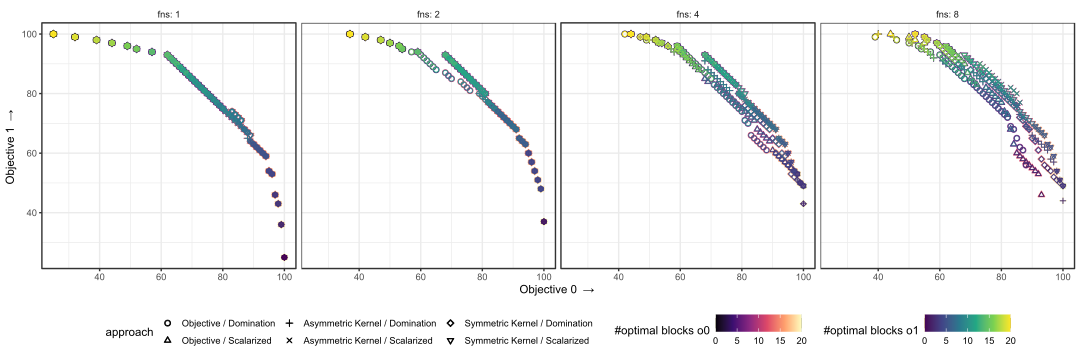

In [57]:
%%R -i fronts_tested_oboth_f -i problem_name -i preferred_ordering_front -w 15 -h 5

fronts_tested_oboth_f$approach = factor(fronts_tested_oboth_f$approach, levels=preferred_ordering_front)

plt <- ggplot(fronts_tested_oboth_f,
              aes(
                  x=`fitness o0`,
                  y=`fitness o1`,
                  shape=`approach`),
              fill=NA,
              ) +
geom_point(alpha=1, size=2, aes(color=`#optimal blocks o0`)) +
# scale_color_distiller(palette = "Reds") +
scale_color_viridis_c(option="A") +
new_scale_color() +
geom_point(alpha=1, aes(color=`#optimal blocks o1`)) +
# scale_color_distiller(palette = "Blues") +
scale_colour_viridis_c(option="D") +
scale_shape_manual(values=1:length(preferred_ordering_front)) +
labs(x = expression("Objective 0 " %->% ""), y = expression("Objective 1 " %->% "")) +
facet_grid(. ~ fns, label=label_both) +
theme_bw() +
theme(strip.background = element_rect(fill = NA, color=NA),
    legend.position = "bottom")

ggsave("2021-12-23-best_of_traps_blockcount_twoscale.pdf", device=cairo_pdf)

plt

In [58]:
%%R -i fronts_tested_oboth_f -i problem_name -i preferred_ordering_front -w 15 -h 5

fronts_tested_oboth_f$approach = factor(fronts_tested_oboth_f$approach, levels=preferred_ordering_front)

plt <- ggplot(fronts_tested_oboth_f,
    aes(
        x=`fitness o0`,
        y=`fitness o1`,
        shape=`approach`,
        text=paste(
            "Approach: ", `approach`, "\n",
            "Objective 0: ", `fitness o0`, "\n",
            "# Optimal Blocks (for objective 0): ", `#optimal blocks o0`, "\n",
            "Objective 1: ", `fitness o1`, "\n",
            "# Optimal Blocks (for objective 1): ", `#optimal blocks o1`, "\n"
        )
        ),
        fill=NA,
    ) +
    geom_point(alpha=1, size=4, aes(color=`#optimal blocks o0`)) +
    # scale_color_distiller(palette = "Reds") +
    # scale_color_viridis_c(option="A") +
    # new_scale_color() +
    geom_point(alpha=1, aes(color=`#optimal blocks o1`)) +
    # scale_color_distiller(palette = "Blues") +
    scale_colour_viridis_c(option="A") + # or D
    scale_shape_manual(values=1:length(preferred_ordering_front)) +
    labs(x = expression("Objective 0 " %->% ""), y = expression("Objective 1 " %->% "")) +
    facet_grid(. ~ fns, label=label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA),
    legend.position = "bottom")

ggsave("2021-12-23-best_of_traps_blockcount_singlescale.pdf", device=cairo_pdf)
# pltplotly <- ggplotly(plt, tooltip="text")
# htmlwidgets::saveWidget(pltplotly, "plot_blockcount_interactive.html")
# ggsave("plot_blockcount_single_scale.pdf")
# plt

R[write to console]: Saving 15 x 5 in image

